Transformer Code:

Differences with patent:

1. The paper has 2 skip connections, the embedded input with the output of the multihead and the output of the multihead with the output of the feed forward. The code given adds the embedds to the output of the forward.


Changes:
1. Fixing the skip connections
```
 return x + self.think(x + self.comm(x))
```
into
```
mh = x + self.comm(x)
return mh + self.think(mh)
```

2. Added a dropout layer to the multiheaded attention.

3. Changed from predicting the next character to predicting the next word. This
generated text with more meaning. Meaning is between words, not between characters, that's the whole point of K, Q and V.

4. The code was not working with cuda, only cpu. it was missing .to(self.device) for the layers in the prep function, so the prep tensors were being stored into CPU and conflicting with the model.

5. The same value for when to evaluate was being used for how many evaluations should be done. These are 2 different concepts, so I set the number of evaluations to 10 and the iterations on which to evaluate I left it as the parameter.

6. Added tqdm to provide nice feedback during the training process.



In [61]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
import re

''' Look at all previous tokens to generate next
    @Author: Uzair Ahmad
    2022
    +TransformerBlock
'''


class TransformerBlockLM(nn.Module):
    class TransformerBlock(nn.Module):
        def __init__(self, head_count, in_size, out_size):
            super().__init__()
            self.comm = TransformerBlockLM.MultiHeadAttention(head_count=head_count,
                                                              in_size=in_size,
                                                              out_size=out_size)
            self.think = TransformerBlockLM.MLP(embed_size=out_size)

        def forward(self, x):
            mh = x + self.comm(x)
            return mh + self.think(mh)

    class MLP(nn.Module):
        # FFNN (embed_size, embed_size*4, embed_size)
        def __init__(self, embed_size):
            super().__init__()
            self.mlp = nn.Sequential(nn.Linear(embed_size, embed_size * 4),
                                     nn.ReLU(),
                                     nn.Linear(embed_size * 4, embed_size))
            self.layerNorm = nn.LayerNorm(embed_size)

        def forward(self, x):  # think
            return self.layerNorm(self.mlp(x))  # paper - after
            # return self.mlp(self.layerNorm(x)) # alternate - before

    class MultiHeadAttention(nn.Module):
        """
        multiple parallel SA heads (communication among words)
        """

        def __init__(self, head_count, in_size, out_size):
            super().__init__()
            self.heads = nn.ModuleList(
                TransformerBlockLM.SelfAttentionHead(in_size, out_size // head_count)
                for _ in range(head_count)
            )
            self.dropout = nn.Dropout(0.5)
            self.layerNorm = nn.LayerNorm(out_size)
            # self.proj = nn.Linear(out_size, out_size)

        def forward(self, x):
            # concat over channel/embeddings_size dimension
            return self.dropout(self.layerNorm(torch.cat([head(x) for head in self.heads], dim=-1)))
            #return self.layerNorm(torch.cat([head(x) for head in self.heads], dim=-1))  # paper - after
            # return torch.cat([head(self.layerNorm(x)) for head in self.heads], dim=-1) # alternate - before
            # return self.proj(torch.cat([head(x) for head in self.heads], dim=-1))

    class SelfAttentionHead(nn.Module):
        def __init__(self, in_size, out_size):
            """
            in_size is embed_size
            out_size is head_size
            """
            super().__init__()
            self.head_size = out_size
            self.K = nn.Linear(in_size, self.head_size, bias=False)
            self.Q = nn.Linear(in_size, self.head_size, bias=False)
            self.V = nn.Linear(in_size, self.head_size, bias=False)

        def forward(self, x):
            keys = self.K(x)
            queries = self.Q(x)
            # affinities :
            # all the queries will dot-product with all the keys
            # transpose (swap) second dimension (input_length) with third (head_size)
            keys_t = keys.transpose(1, 2)
            autocorrs = (queries @ keys_t) * (self.head_size ** -0.5)  # (batch_size x input_length x input_length)
            '''
            (batch_size x input_length x embed_size) @ (batch_size x embed_size x input_length) ----> (batch_size x input_length x input_length)
            '''
            autocorrs = torch.tril(autocorrs)
            autocorrs = autocorrs.masked_fill(autocorrs == 0, float('-inf'))
            autocorrs = torch.softmax(autocorrs, dim=-1)
            values = self.V(x)  # (batch_size x input_length x head_size)
            out = autocorrs @ values
            return out

    def __init__(self, batch_size=4,
                 input_length=8,
                 embed_size=16,
                 sa_head_size=8,
                 sa_multihead_count=4,
                 pos_embed=False,
                 include_mlp=False):
        super().__init__()
        self.blocks = None
        self.ffn = None
        self.sa_heads = None
        # sa_head_size head_size of self-attention module
        self.sa_head_size = sa_head_size
        self.sa_multihead_count = sa_multihead_count

        self.val_data = None
        self.train_data = None
        self.val_text = None
        self.train_text = None
        self.K = None
        self.linear_sahead_to_vocab = None
        self.vocab = None
        self.token_embeddings_table = None
        self.vocab_size = None
        self.encoder = None
        self.decoder = None
        self.vocab_size: int
        self.is_pos_emb = pos_embed
        self.include_mlp = include_mlp
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        # input_length = how many consecutive tokens/chars in one input
        self.input_length = input_length
        # batch_size = how many inputs are going to be processed in-parallel (on GPU)
        self.batch_size = batch_size
        # embed_size = embedding size
        self.embed_size = embed_size

        self.lm_head = None
        self.position_embeddings_table = None

    def forward(self, in_ids, target=None):
        in_ids_emb = self.token_embeddings_table(in_ids[:, -self.input_length:])
        if self.is_pos_emb:
            in_ids_pos_emb = self.position_embeddings_table(
                torch.arange(in_ids[:, -self.input_length:].shape[1], device=self.device)
            )
            in_ids_emb = in_ids_emb + in_ids_pos_emb

        block_outputs = self.blocks(in_ids_emb)
        logits = self.linear_sahead_to_vocab(block_outputs)  # compute

        if target is None:
            ce_loss = None
        else:
            batch_size, input_length, vocab_size = logits.shape
            logits_ = logits.view(batch_size * input_length, vocab_size)
            targets = target.view(batch_size * input_length)
            ce_loss = F.cross_entropy(logits_, targets)
        return logits, ce_loss

    def fit(self, train_iters=100, eval_iters=10, lr=0.0001):
        """
        train_iters = how many training iterations
        eval_iters = how many batches to evaluate to get average performance
        """
        train_losses = []
        val_losses = []
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for iteration in tqdm(range(train_iters), total= train_iters):
            if iteration % eval_iters == 0:
                avg_loss = self.eval_loss(10)
                val_losses.append(avg_loss['eval'])
                print(f"iter {iteration}: train {avg_loss['train']} val {avg_loss['eval']}")

            inputs, targets = self.get_batch(split='train')
            _, ce_loss = self(inputs, targets)
            train_losses.append(ce_loss.item())
            optimizer.zero_grad(set_to_none=True)  # clear gradients of previous step
            ce_loss.backward()  # propagate loss back to each unit in the network
            optimizer.step()  # update network parameters w.r.t the loss
        # torch.save(self, 'sa_pos_')
        return train_losses, val_losses

    def generate(self, context_token_ids, max_new_tokens):
        for _ in range(max_new_tokens):
            token_rep, _ = self(context_token_ids)
            last_token_rep = token_rep[:, -1, :]
            probs = F.softmax(last_token_rep, dim=1)
            next_token = torch.multinomial(probs, num_samples=1)
            context_token_ids = torch.cat((context_token_ids, next_token), dim=1)
        output_text = self.decoder(context_token_ids[0].tolist())
        return output_text

    @torch.no_grad()  # tell torch not to prepare for back-propagation (context manager)
    def eval_loss(self, eval_iters):
        perf = {}
        # set dropout and batch normalization layers to evaluation mode before running inference.
        self.eval()
        for split in ['train', 'eval']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                tokens, targets = self.get_batch(split)  # get random batch of inputs and targete
                _, ce_loss = self(tokens, targets)  # forward pass
                losses[k] = ce_loss.item()  # the value of loss tensor as a standard Python number
            perf[split] = losses.mean()
        self.train()  # turn-on training mode-
        return perf

    def prep(self, corpus):
        self.vocab = sorted(list(set(re.split('(\W)',corpus))) + [" "])
        self.vocab_size = len(self.vocab)

        print(self.vocab[:10])
        c2i = {c: i for i, c in
               enumerate(self.vocab)}  # char c to integer i map. assign value i for every word in vocab
        i2c = {i: c for c, i in c2i.items()}  # integer i to char c map
        self.encoder = lambda doc: [c2i[c] for c in doc]
        self.decoder = lambda nums: ''.join([i2c[i] for i in nums])

        split_text = re.split('(\W)', corpus)
        n = len(split_text)
        self.train_text = split_text[:int(n * 0.9)]
        self.val_text = split_text[int(n * 0.9):]
        #print(f"Train: {(self.train_text)} Val: {(self.val_text)}")

        self.train_data = torch.tensor(self.encoder(self.train_text), dtype=torch.long)
        self.val_data = torch.tensor(self.encoder(self.val_text), dtype=torch.long)
        #print(self.train_data.shape, self.val_data.shape)

        # look-up table for embeddings (vocab_size x embed_size)
        # it will be mapping each token id to a vector of embed_size
        # a wrapper to store vector representations of each token
        self.token_embeddings_table = \
            nn.Embedding(self.vocab_size, self.embed_size).to(self.device)

        if self.is_pos_emb:
            self.position_embeddings_table = nn.Embedding(self.input_length, self.embed_size).to(self.device)

        self.blocks = nn.Sequential(
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
        ).to(self.device)
        # linear projection of sa_head output to vocabulary
        self.linear_sahead_to_vocab = nn.Linear(self.sa_head_size, self.vocab_size).to(self.device)

    def get_batch(self, split='train'):

        data = self.train_data if split == 'train' else self.val_data
        # get random chunks of length batch_size from data
        ix = torch.randint(len(data) - self.input_length,
                           (self.batch_size,))
        inputs_batch = torch.stack([data[i:i + self.input_length] for i in ix])
        targets_batch = torch.stack([data[i + 1:i + self.input_length + 1] for i in ix])
        inputs_batch = inputs_batch.to(self.device)
        targets_batch = targets_batch.to(self.device)
        # inputs_batch is
        return inputs_batch, targets_batch

In [47]:
with open('./emily_dickonson.txt', 'r') as f:
    text = f.read()

#text = 'a quick brown fox jumps over the lazy dog.\n ' \
#        'lazy dog and a quick brown fox.\n' \
#        'the dog is lazy and the fox jumps quickly.\n' \
#        'a fox jumps over the dog because he is lazy.\n' \
#        'dog is lazy and fox is brown. she quickly jumps over the lazy dog.'


model = TransformerBlockLM(batch_size=64,
                           input_length=32,
                           embed_size=128,
                           sa_multihead_count=8,
                           sa_head_size=128,
                           pos_embed=True,
                           include_mlp=True)
model = model.to(model.device)
print(model.device)
model.prep(text)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print(f'params {sum([np.prod(p.size()) for p in model_parameters])}')
input_batch, output_batch = model.get_batch(split='train')
input_batch = input_batch.to(model.device) # fix
output_batch = output_batch.to(model.device) #fix

_, _ = model(input_batch, output_batch)
model.fit(train_iters=3000, eval_iters=1000, lr=1e-3)
outputs = model.generate(context_token_ids=torch.zeros((1, 1),
                                                        dtype=torch.long,
                                                        device=model.device),
                         max_new_tokens=1000)
print(outputs)

cuda:0
['', '\n', ' ', ' ', '!', '"', "'", '(', ')', '*']
params 2751030


  0%|          | 0/3000 [00:00<?, ?it/s]

iter 0: train 11.592584609985352 val 11.679858207702637
iter 1000: train 2.1773369312286377 val 2.855206251144409
iter 2000: train 1.234906792640686 val 3.414564847946167

Like stone of the Death,
Crowned, crowing on my shoe,
A hurrying home the ear
The birds unheard like a summer day
And purple at night,
And then I know her less
Until so overheard their gown;
Their glory I am it so ample long,
    And bells that boldly ring
To tell him that old faded midnight.
It was a word?

VIII.

THE BLUEBIRD.

The birds pall
Of trees is put their haunted door.

Her forehead stopped as this crownWith last delight In another pair. In door,
I mean an hour than a gate
   And though I starve!

XXVII.

THE SPIDER."

He? She not I should miss —
Repairing everywhere, among the two,
And a little green chill could upon my board,
Know the fair morning is crested
There is a bolder mean might,
A idleness of light of a tune
Where this great be.
Make mighty not notice,
Or whether died it with a match,
Perusal by

Warren Buffet's Annual Letter

One way to calculate Perplexity is as the exponent of Cross Entropy and since our loss function is CE, we will just exponentiate its loss.

The perplexity of the model was 24.430566787719727

There are a couple of interesting things about the generated text:


1.   It tends to put together numbers and words related to quantities like *\$900 million*,  *income of cash $5,571,000*, etc.
2.   parts of sentences actually make sense like *the experience in relation to Berkshire's future associates* or *to Berkshire's credit shares sell*, etc.
3. Long text doesn't make much sense and there's no principal idea of the text.



In [81]:
with open('./WarrenBuffet.txt', 'r') as f:
    text = f.read()

#text = 'a quick brown fox jumps over the lazy dog.\n ' \
#        'lazy dog and a quick brown fox.\n' \
#        'the dog is lazy and the fox jumps quickly.\n' \
#        'a fox jumps over the dog because he is lazy.\n' \
#        'dog is lazy and fox is brown. she quickly jumps over the lazy dog.'


model = TransformerBlockLM(batch_size=64,
                           input_length=32,
                           embed_size=128,
                           sa_multihead_count=8,
                           sa_head_size=128,
                           pos_embed=True,
                           include_mlp=True)
model = model.to(model.device)
print(model.device)
model.prep(text)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print(f'params {sum([np.prod(p.size()) for p in model_parameters])}')
input_batch, output_batch = model.get_batch(split='train')
input_batch = input_batch.to(model.device) # fix
output_batch = output_batch.to(model.device) #fix

_, _ = model(input_batch, output_batch)
train_losses, val_losses = model.fit(train_iters=2001, eval_iters=100, lr=1e-3)

cuda:0
['', '\n', ' ', ' ', '!', '"', '$', '%', '&', "'"]
params 2873876


  0%|          | 0/2001 [00:00<?, ?it/s]

iter 0: train 10.283998489379883 val 10.245943069458008
iter 100: train 3.3573544025421143 val 3.5155720710754395
iter 200: train 3.2099411487579346 val 3.4268996715545654
iter 300: train 3.0835928916931152 val 3.39740252494812
iter 400: train 3.0169174671173096 val 3.3153164386749268
iter 500: train 2.890005588531494 val 3.2534050941467285
iter 600: train 2.815544605255127 val 3.197960376739502
iter 700: train 2.672576427459717 val 3.172865390777588
iter 800: train 2.602520704269409 val 3.1345958709716797
iter 900: train 2.49886155128479 val 3.0780739784240723
iter 1000: train 2.403043746948242 val 3.0551822185516357
iter 1100: train 2.2732670307159424 val 3.1219496726989746
iter 1200: train 2.2144598960876465 val 3.1079070568084717
iter 1300: train 2.142487049102783 val 3.0861525535583496
iter 1400: train 2.0620405673980713 val 3.064509630203247
iter 1500: train 1.9592342376708984 val 3.060319185256958
iter 1600: train 1.9579246044158936 val 3.074122428894043
iter 1700: train 1.82672

In [83]:
perplexity = torch.exp(torch.tensor(val_losses[-1]))
print(f'Perplexity: {perplexity}')

Perplexity: 24.430566787719727


<ipython-input-83-f3cd6966edc9>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perplexity = torch.exp(torch.tensor(val_losses[-1]))


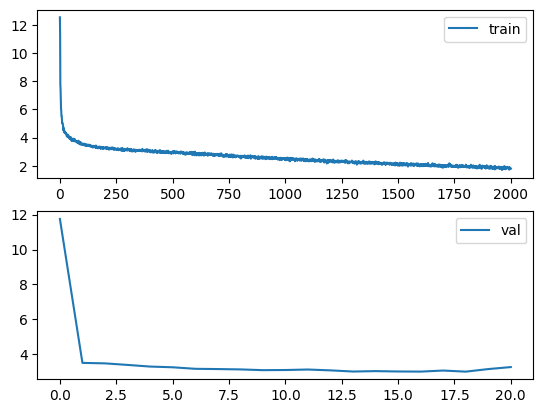

In [77]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2)
ax[0].plot(train_losses, label='train')
ax[1].plot(val_losses, label='val')
ax[0].legend()
ax[1].legend()
plt.show()


In [85]:
outputs = model.generate(context_token_ids=torch.zeros((1, 1),
                                                        dtype=torch.long,
                                                        device=model.device),
                         max_new_tokens=1000)
print(outputs)


Many businesses continue to see across-demand for this powerful annual meeting to Berkshire's credit 
shares sell and guides 19 to increase or advantage. This main sector: Relying would fill repurchases is to give far book accounting rules common reserve, than any 
newspaper jungle:45 of the $ $900 million in the management or Business and $attitudes to million. Just with had annually of your convenience, the amount of Wall Street Street for his results. 

In our positions, foreign the experience in relation to Berkshire's future associates, not no he urges you are disapprove of billions of dollars in 2006. In very large bolt-on us in the 2003 of the Kansas City, and car have 
that Berkshire Earnings to pick and participate and regulators to meet $5) 
$100 income of cash $5,571,000 

1975 $21*00 $19 3million of $1,314 $1,728 
$1,113 
$ 1,324 $61,533 paid from our settlement took to school me, not 
highs. When his potential and Six considerably his strongest and our country's focus of 